In [3]:
import csv
import cv2
import numpy as np
from matplotlib import pyplot as plt
from time import time
import keras
import inspect
import sklearn
from sklearn.model_selection import train_test_split

### 1 Read csv files containing trainingdata

In [4]:
t0=time() #set starting point for time used

samples = []; #Define samples array

#paths = ['exampledata/'] # Exampledata
paths=['recdata/data1/','recdata/data2/'] #own data --> 2 Laps clockwise, 2Laps counter clockwise


for path in paths:
    reader = csv.reader(open(path+'driving_log.csv')) #read csv iformation
    for line in reader:
        for idx,entry in enumerate(line):
            if '.jpg' in entry:
                entry = entry.replace('\\','/') #replace backslash by slash
                line[idx] = './' + path + 'IMG/'+entry.split('/')[-1]
        samples.append(line)

time_taken=time()-t0
print('Reading csv took',time_taken,'seconds')
print(len(samples),'samples available')

Reading csv took 0.06090497970581055 seconds
3787 samples available


### 1.1 Use all samples including left and right images with penaltys

In [5]:
t0=time() #set starting point for time used

allsamples = []

for line in samples:
    allsamples.append([line[0], line[3], 0]) #Use center image and steerAngle
    allsamples.append([line[1], float(line[3])+0.15, 0]) #Use left image and apply a penalty of to steering angle
    allsamples.append([line[2], float(line[3])-0.15, 0]) #Use right image and apply a penalty of to steering angle
    #A 0 was added to the end of each line to tell the generator, that the line should not be mirrored
time_taken=time()-t0
print('Generating array took',time_taken,'seconds')
print(len(allsamples),'samples available')

Generating array took 0.008180618286132812 seconds
11361 samples available


### 2 Augment data giving mirror identificator

In [6]:
t0 = time()

allsamples_mirror = []

for line in allsamples:
    allsamples_mirror.append([line[0],line[1],1])
    #A 1 was added to the end of each line to tell the generator, that the line should be mirrored. 
    #One could simply randomnly decide iside the generator, but this way you see how many samples are created
allsamples.extend(allsamples_mirror) #add mirroredsamples to samples array
allsamples = sklearn.utils.shuffle(allsamples) #shuffle samples

time_taken=time()-t0
print('Creating complete sample list took',time_taken,'seconds')
print(len(allsamples),'samples available')

Creating complete sample list took 0.009922981262207031 seconds
22722 samples available


### 3 Create generator function to create training data on the fly

In [7]:
def generator(samples, batch_size=128):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples) # shuffle smaples
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = [] #initialize images list
            angles = [] #initialize angles list
            for batch_sample in batch_samples:
                img = cv2.imread(batch_sample[0])   #read image
                ang = float(batch_sample[1])        #get angle
                if batch_sample[2]:         #flip image if identifier is 1
                    img = np.fliplr(img)    #flip left to right
                    ang = -1*ang            #use negative angle
                images.append(img)          #append image to images list
                angles.append(ang)          #append angle to angles list

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

### 4 Plot ten random images(fliped images possible) to see generator output

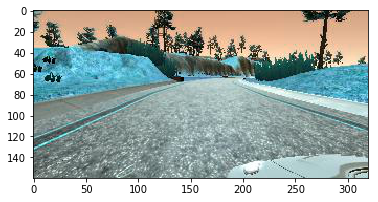

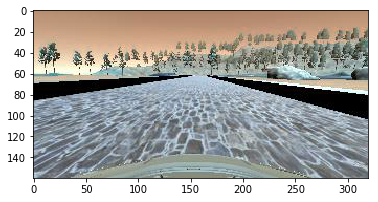

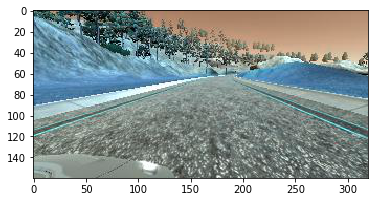

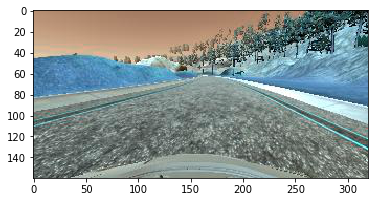

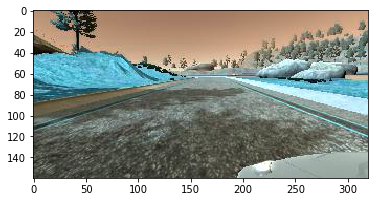

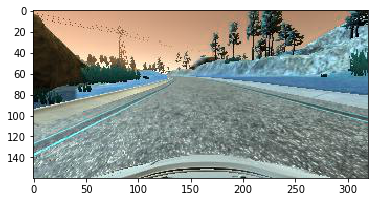

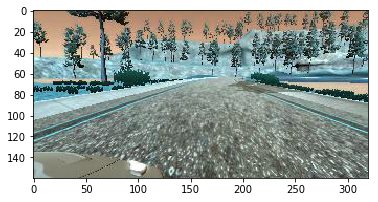

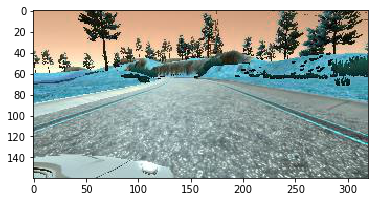

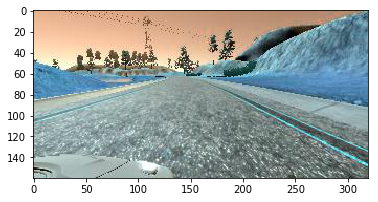

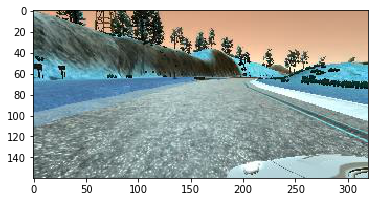

In [17]:
%matplotlib inline
samplesRnd = next(generator(allsamples,batch_size=10))
for sample in samplesRnd:
    for item in sample:
        if len(item.shape)>1:
            plt.figure()
            plt.imshow(item)

### 5 Create KERAS model

In [6]:
img = keras.layers.Input(shape=(160,320,3)) # Create Input named img
normal_img = keras.layers.Lambda(lambda x: x/255-0.5, input_shape=(160,320,3))(img) #Add Lamda Layer
cropped_img = keras.layers.Cropping2D(((70,25),(0,0)))(normal_img) #Crop image
l2_inp = keras.layers.Convolution2D(14,6,8,subsample=(2,2),activation='relu')(cropped_img) #Feed through convolution
l2_out = keras.layers.Dropout(0.1)(l2_inp) #Apply dropout to layer drop 50%
# Add inception module [Parallel 3x3Conv,5x5Conv,3x3MaxPool]
c3x3inp = keras.layers.Convolution2D(8, 1, 1,border_mode='same', activation='relu')(l2_out)
c3x3 = keras.layers.Convolution2D(8,3,3, border_mode='same', activation='relu')(c3x3inp)
c5x5inp = keras.layers.Convolution2D(8, 1, 1, border_mode='same', activation='relu')(l2_out)
c5x5 = keras.layers.Convolution2D(8,5,5, border_mode='same', activation='relu')(c5x5inp)
pool3x3 = keras.layers.MaxPooling2D((3,3), strides=(1,1), border_mode='same')(l2_out)
pool3x3out = keras.layers.Convolution2D(8, 1, 1, border_mode='same', activation='relu')(pool3x3)
l3_inp = keras.engine.topology.merge([c3x3,c5x5,pool3x3out],mode='concat', concat_axis=3)
l3_1inp = l2_out = keras.layers.Dropout(0.25)(l3_inp) #Apply dropout to layer drop 50%
l3_out = keras.layers.Flatten()(l3_1inp) #Flatten
output = keras.layers.Dense(1)(l3_out) #Output steer angle
model = keras.models.Model(input=img, output=output) #Create Keras model
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 160, 320, 3)   0                                            
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 160, 320, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 65, 320, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 30, 157, 14)   2030        cropping2d_1[0][0]               
___________________________________________________________________________________________

### 6 Train network

In [7]:
t0 = time()

# Split data to traib and validation data
train_samples, validation_samples = sklearn.model_selection.train_test_split(allsamples, test_size=0.2) 

train_generator = generator(train_samples, batch_size=128)
validation_generator = generator(validation_samples, batch_size=128)

savefname = 'model.h5'

model.compile(loss = 'mse', optimizer = 'adam')
model.fit_generator(train_generator, samples_per_epoch= len(train_samples), validation_data=validation_generator,nb_val_samples=len(validation_samples), nb_epoch=5)

model.save('saved/' + savefname)

time_taken=time()-t0
print('training operation took',time_taken,'seconds \n Model saved to: ', savefname)

Epoch 1/5
18177/18177 [==============================] - 82s - loss: 0.1024 - val_loss: 0.0323
Epoch 2/5
18177/18177 [==============================] - 80s - loss: 0.0309 - val_loss: 0.0295
Epoch 3/5
18177/18177 [==============================] - 79s - loss: 0.0281 - val_loss: 0.0279
Epoch 4/5
18177/18177 [==============================] - 79s - loss: 0.0262 - val_loss: 0.0265
Epoch 5/5
18177/18177 [==============================] - 79s - loss: 0.0241 - val_loss: 0.0262
training operation took 402.83235001564026 seconds 
 Model saved to:  model.h5
